<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning For Maximum Power Point Tracking Prediction In PV System (Apache Spark)**

Explanation of this project can be found in https://www.mdpi.com/1996-1073/14/22/7806


In [1]:
# Installing required packages
!pip install pyspark
!pip install findspark

import findspark
findspark.init()

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 45.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b0651c9b7a93c1334c3e6fe5b6ff946c6c2c8f6e2c110b7fdc28b98306759ad8
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [146]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from google.colab import files
import io

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

##Loading data into a Pandas DataFrame

In [6]:
uploaded = files.upload()  

data= io.BytesIO(uploaded['PV_data.xlsx'])
# read_file = csv.reader(codecs.iterdecode(data, 'utf-8'), delimiter=',')
df = pd.read_excel(data)

Saving PV_data.xlsx to PV_data.xlsx


In [211]:
df.head()

,Time,T_pv00,G_pv00,I_pv00,V_pv00,P_pv00,Time01,T_pv01,G_pv01,I_pv01,V_pv01,P_pv01,Time02,T_pv02,G_pv02,I_pv02,V_pv02,P_pv02,Time03,T_pv03,G_pv03,I_pv03,V_pv03,P_pv03,Time04,T_pv04,G_pv04,I_pv04,V_pv04,P_pv04,Time05,T_pv05,G_pv05,I_pv05,V_pv05,P_pv05,Time06,T_pv06,G_pv06,I_pv06,V_pv06,P_pv06,Time07,T_pv07,G_pv07,I_pv07,V_pv07,P_pv07,Time08,T_pv08,G_pv08,I_pv08,V_pv08,P_pv08,Time09,T_pv09,G_pv09,I_pv09,V_pv09,P_pv09,Time10,T_pv10,G_pv10,I_pv10,V_pv10,P_pv10
0,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,38.774414,673.645019,0.272101,43.283744,11.777559,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.009992,38.774414,673.645020,0.272101,43.283744,11.777559,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.03,15.510254,109.497070,1.052417,0.991695,1.043676,0.030000,23.333740,262.939453,2.591854,1.101946,2.856084,0.029995,14.859619,427.917480,4.122805,1.176492,4.850447
2,0.019984,38.790283,673.461914,0.272138,43.284969,11.779480,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.019984,38.790283,673.461914,0.272138,43.284969,11.779480,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.06,15.526123,109.680176,1.052703,0.992231,1.044524,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.059991,14.796143,427.734375,4.122881,1.176114,4.848978
3,0.029976,38.822021,674.011231,0.271990,43.285665,11.773278,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.029976,38.822021,674.011230,0.271990,43.285665,11.773278,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.09,15.557861,110.595703,1.052860,0.991691,1.044112,0.090000,23.397217,263.671875,2.592861,1.103698,2.861735,0.089986,14.653320,426.452637,4.123063,1.175789,4.847853
4,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.12,15.573730,109.863281,1.052867,0.992191,1.044645,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.119981,14.827881,428.649902,4.123685,1.176678,4.852250


In [76]:
# data for the maximum power point
url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'

In [77]:
df1 = pd.read_excel(url)
print(type(df1))
df1.head()

<class 'pandas.core.frame.DataFrame'>


,Pmax,Vmax,Imax,G,T
0,146.2333,38.3969,3.808466,426.2695,17.0813
1,149.2753,35.1044,4.252324,437.4390,18.0334
2,150.0502,38.0550,3.942983,446.4111,19.7314
3,154.4916,36.5494,4.226926,452.4536,20.3027
4,156.3199,36.4111,4.293194,459.2285,21.3342


#Data visualization 

In [75]:
# determination of x-axis and y-axis 
col=df.columns
X=[]   
Y=[]
for i in range(0,len(col),6):
  index=col[i+4] 
  X.append(index)
  index=col[i+4] 
  X.append(index)
  index=col[i]
  X.append(index)
  index=col[i] 
  X.append(index)

  index=col[i+5] 
  Y.append(index)
  index=col[i+3] 
  Y.append(index)
  index=col[i+1]
  Y.append(index)
  index=col[i+2] 
  Y.append(index)
print(X)
print(Y)

['V_pv00', 'V_pv00', 'Time', 'Time', 'V_pv01', 'V_pv01', 'Time01', 'Time01', 'V_pv02', 'V_pv02', 'Time02', 'Time02', 'V_pv03', 'V_pv03', 'Time03', 'Time03', 'V_pv04', 'V_pv04', 'Time04', 'Time04', 'V_pv05', 'V_pv05', 'Time05', 'Time05', 'V_pv06', 'V_pv06', 'Time06', 'Time06', 'V_pv07', 'V_pv07', 'Time07', 'Time07', 'V_pv08', 'V_pv08', 'Time08', 'Time08', 'V_pv09', 'V_pv09', 'Time09', 'Time09', 'V_pv10', 'V_pv10', 'Time10', 'Time10']
['P_pv00', 'I_pv00', 'T_pv00', 'G_pv00', 'P_pv01', 'I_pv01', 'T_pv01', 'G_pv01', 'P_pv02', 'I_pv02', 'T_pv02', 'G_pv02', 'P_pv03', 'I_pv03', 'T_pv03', 'G_pv03', 'P_pv04', 'I_pv04', 'T_pv04', 'G_pv04', 'P_pv05', 'I_pv05', 'T_pv05', 'G_pv05', 'P_pv06', 'I_pv06', 'T_pv06', 'G_pv06', 'P_pv07', 'I_pv07', 'T_pv07', 'G_pv07', 'P_pv08', 'I_pv08', 'T_pv08', 'G_pv08', 'P_pv09', 'I_pv09', 'T_pv09', 'G_pv09', 'P_pv10', 'I_pv10', 'T_pv10', 'G_pv10']


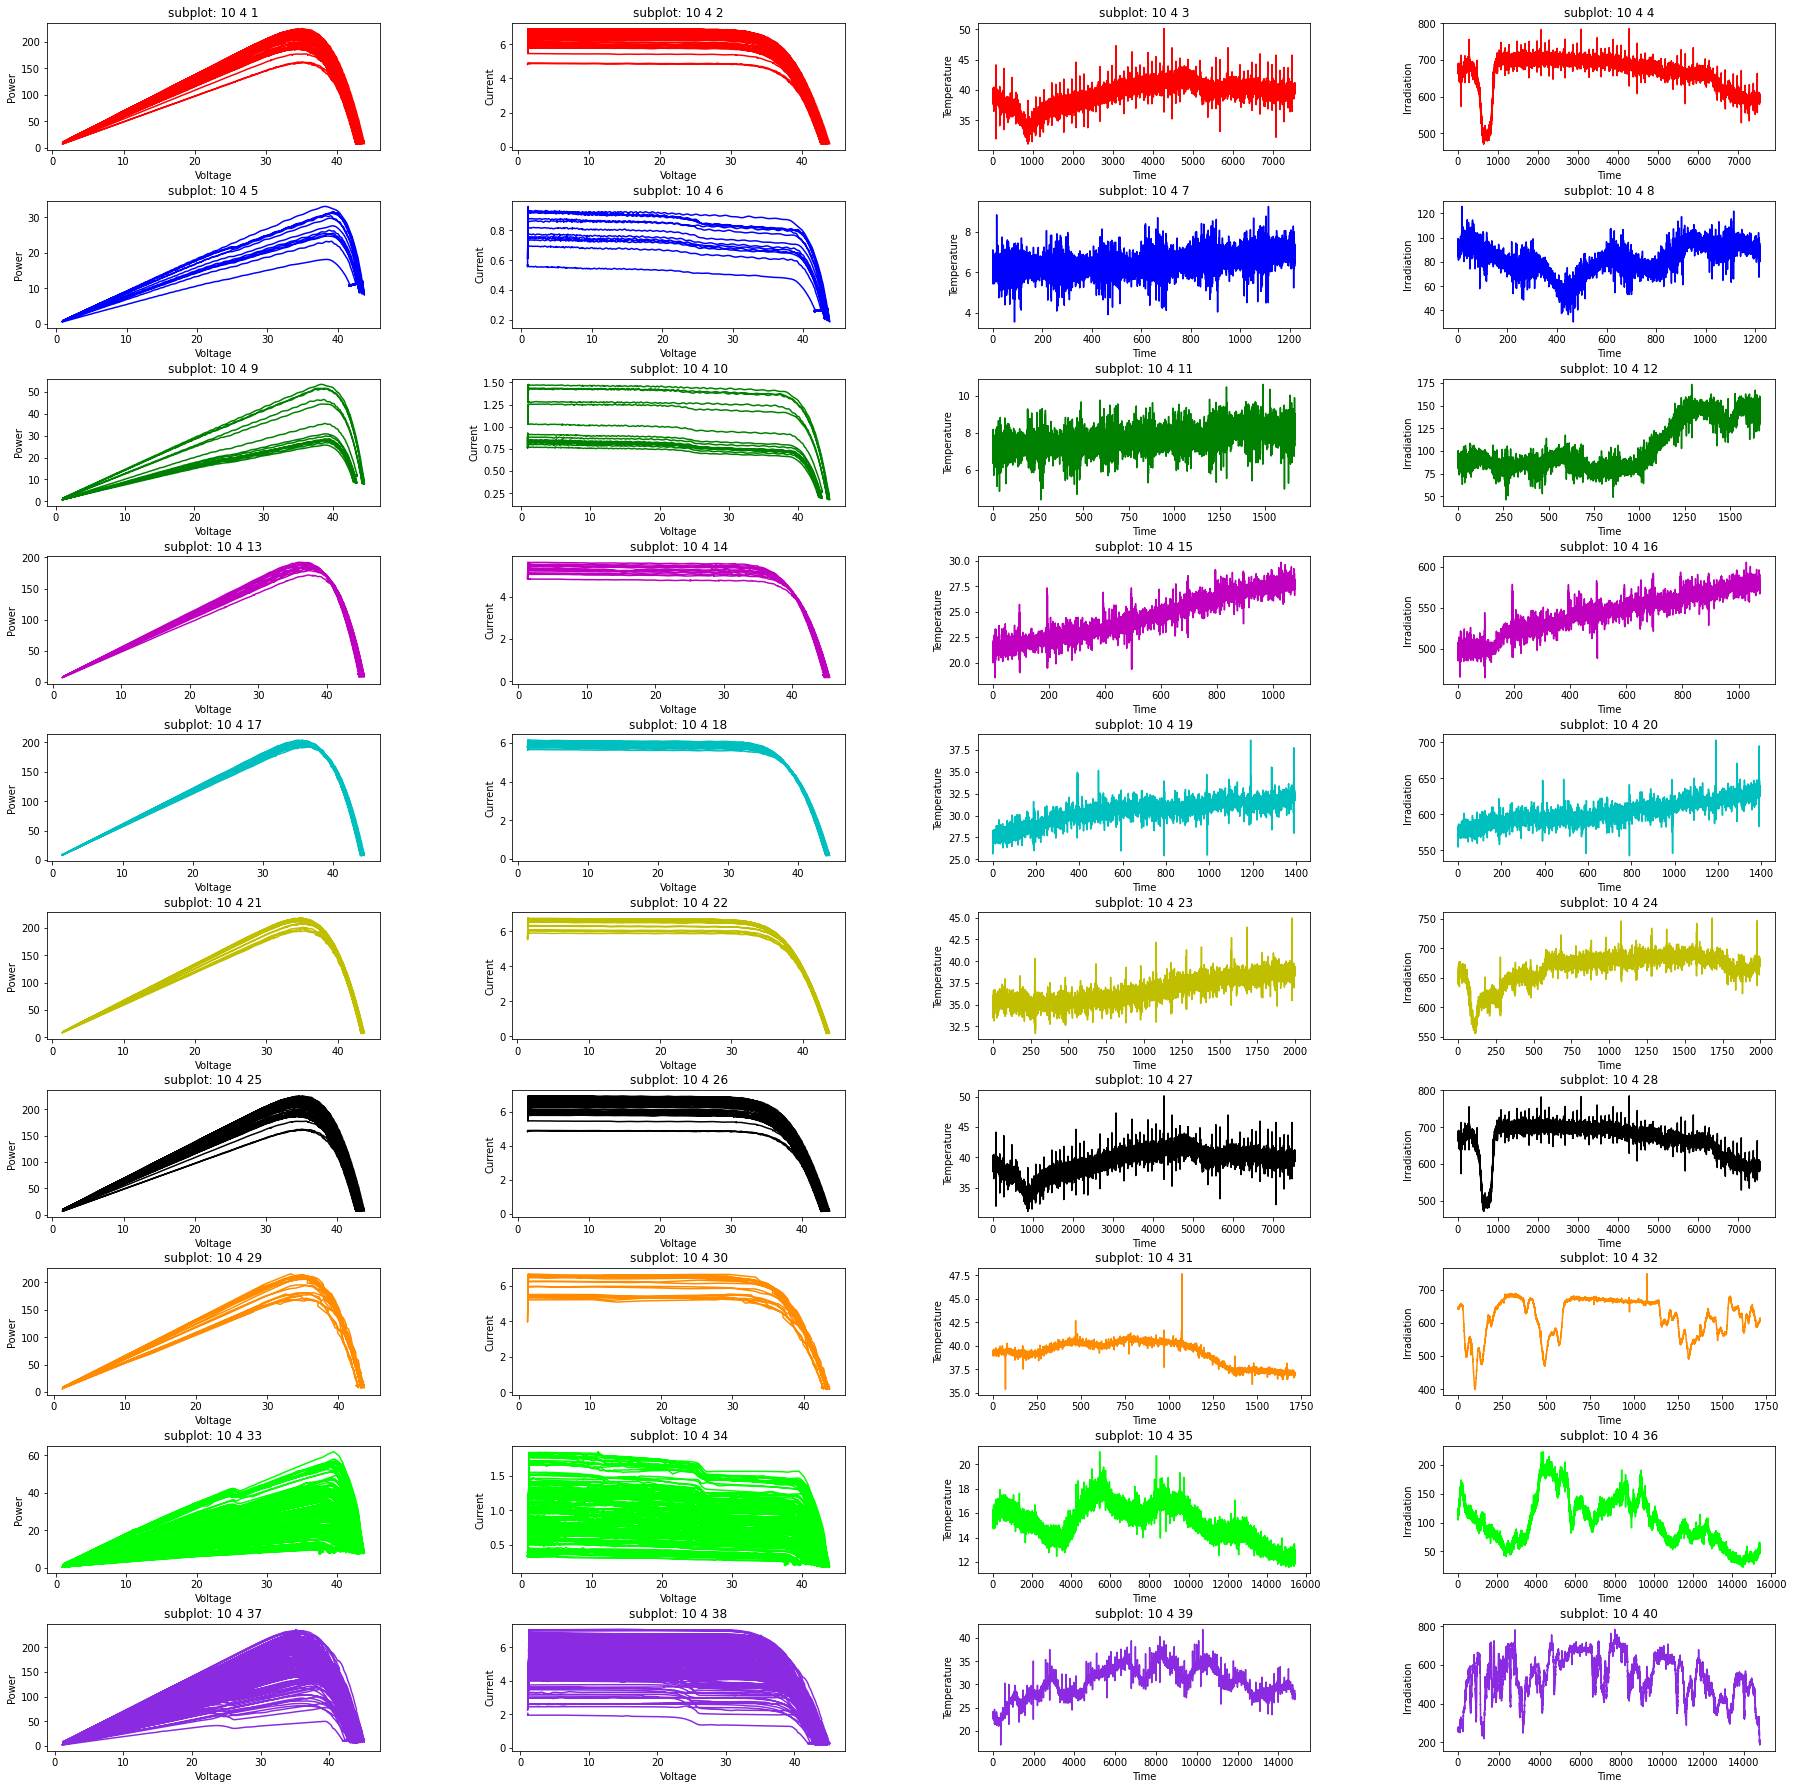

In [227]:
k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis

a = 10  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
itm=0
color=0


fig = plt.figure(figsize=(30,30))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(10): 
  index=0 
  for j in range(4):
    plt.subplot(a, b, c)
    plt.title('subplot: {} {} {}'.format( a, b, c))
    plt.xlabel(Xlab[index])
    plt.ylabel(Ylab[index])
    plt.plot(df[X[itm]], df[Y[itm]],k1[color]) #,label=k2[index]
    c = c + 1
    itm= itm + 1
    index=index+1
  color=color+1
  
plt.show()

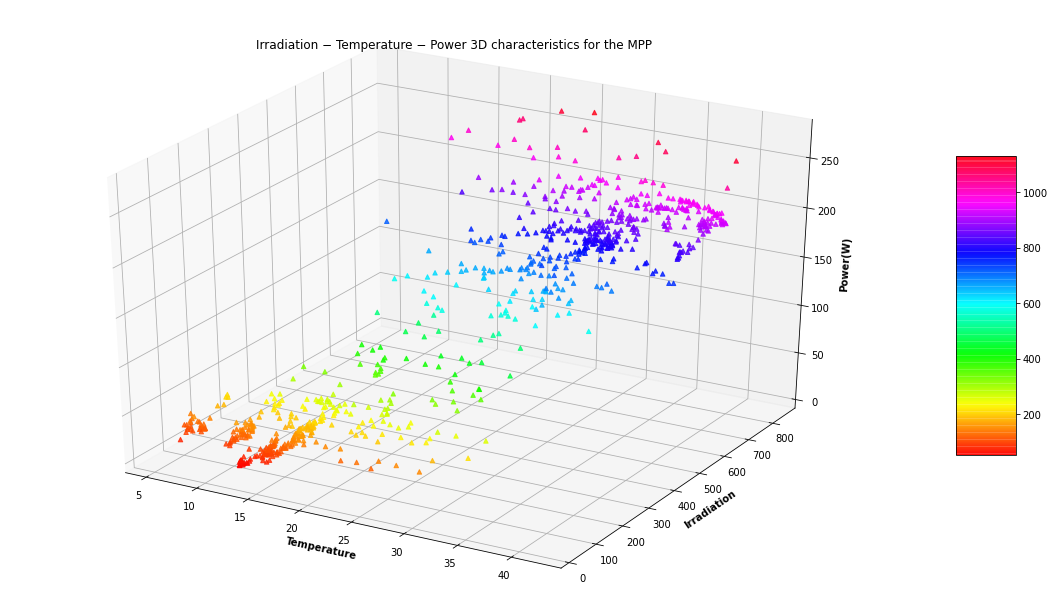

In [91]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df1['T']
y=df1['G']
z=df1['Pmax']
sctt = ax.scatter3D(x, y, z,
                    alpha = .8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Irradiation − Temperature − Power 3D characteristics for the MPP")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
# show plot
plt.show()



# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	

# 3D without color
# threedee = plt.figure(figsize = (12, 8)).gca(projection='3d')
# threedee.scatter(df['T'], df['G'], df['Pmax'])
# threedee.set_xlabel('Temperature')
# threedee.set_ylabel('Irradiation')
# threedee.set_zlabel('Power(W)')
# plt.show()

#converting spark dataframe to pandas dataframe aiming to use matplotlib
# pdf = sdf.toPandas()

## Filtring the Temperature and Irradiation signals

In [157]:

# determination of x-axis and y-axis 
col=df.columns
Time=[]   
Temperature=[]
Irradiation=[]
Current=[]
Voltage=[]
Power=[]

for i in range(0,len(col),6):
  index=col[i] 
  Time.append(index)
  index=col[i+1] 
  Temperature.append(index)
  index=col[i+2]
  Irradiation.append(index)
  index=col[i+3] 
  Current.append(index)
  index=col[i+4] 
  Voltage.append(index)
  index=col[i+5] 
  Power.append(index)


# convert list to array
Time=np.array(Time)
Temperature=np.array(Temperature)
Irradiation=np.array(Irradiation)
Current=np.array(Current)
Voltage=np.array(Voltage)
Power=np.array(Power)


print(Time,'\n', Temperature,'\n',Irradiation,'\n',Current,'\n',Voltage,'\n',Power)



['Time' 'Time01' 'Time02' 'Time03' 'Time04' 'Time05' 'Time06' 'Time07'
 'Time08' 'Time09' 'Time10'] 
 ['T_pv00' 'T_pv01' 'T_pv02' 'T_pv03' 'T_pv04' 'T_pv05' 'T_pv06' 'T_pv07'
 'T_pv08' 'T_pv09' 'T_pv10'] 
 ['G_pv00' 'G_pv01' 'G_pv02' 'G_pv03' 'G_pv04' 'G_pv05' 'G_pv06' 'G_pv07'
 'G_pv08' 'G_pv09' 'G_pv10'] 
 ['I_pv00' 'I_pv01' 'I_pv02' 'I_pv03' 'I_pv04' 'I_pv05' 'I_pv06' 'I_pv07'
 'I_pv08' 'I_pv09' 'I_pv10'] 
 ['V_pv00' 'V_pv01' 'V_pv02' 'V_pv03' 'V_pv04' 'V_pv05' 'V_pv06' 'V_pv07'
 'V_pv08' 'V_pv09' 'V_pv10'] 
 ['P_pv00' 'P_pv01' 'P_pv02' 'P_pv03' 'P_pv04' 'P_pv05' 'P_pv06' 'P_pv07'
 'P_pv08' 'P_pv09' 'P_pv10']


(754689,)

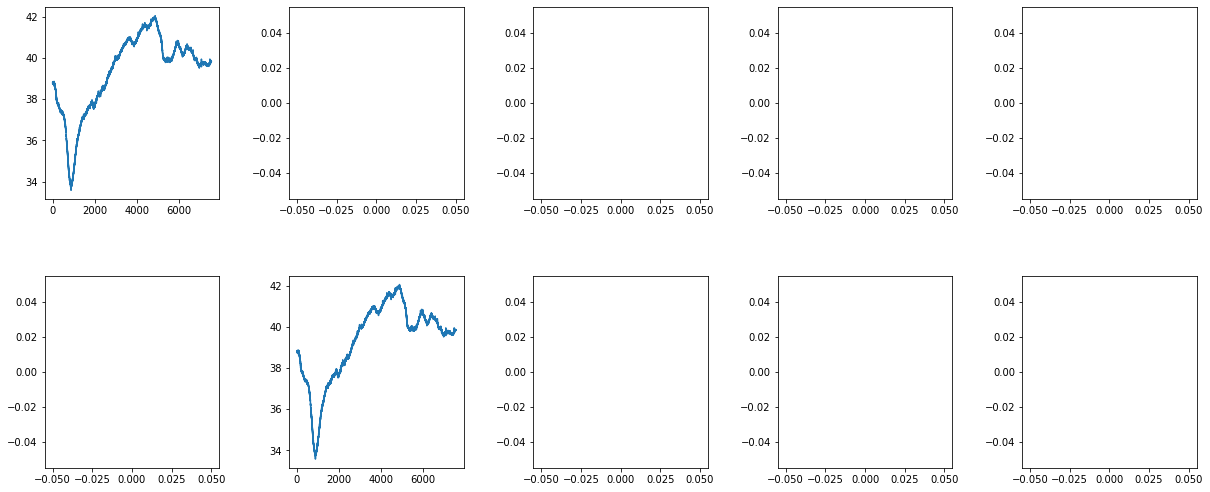

In [226]:
# Define the filter requirements
T = 5.0         # Sample Period
fs = 200.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis
a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter
itm=0
color=0
fig = plt.figure(figsize=(20,8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    F = filtfilt(b, a, data)
    return F




for j in range(0,len(Temperature)-1):
  data=df[Temperature[j]]
  F1 = butter_lowpass_filter(data, cutoff, fs, order)
  plt.subplot(a, b, c)
  plt.plot(df[Time[j]], F1)
  # data=df[Irradiation[j]]
  # F = butter_lowpass_filter(data, cutoff, fs, order)
  c = c + 1


  
# plt.show()







In [ ]:
k1=['r','b','g','m','c','y','k','darkorange','lime','blueviolet',]                      # color
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis

a = 10  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter
itm=0
color=0


fig = plt.figure(figsize=(20,30))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(10): 
  index=0 
  for j in range(4):
    plt.subplot(a, b, c)
    plt.title('subplot: {} {} {}'.format( a, b, c))
    plt.xlabel(Xlab[index])
    plt.ylabel(Ylab[index])
    plt.plot(df[X[itm]], df[Y[itm]],k1[color]) #,label=k2[index]
    c = c + 1
    itm= itm + 1
    index=index+1
  color=color+1
  
plt.show()

In [210]:
df[Temperature[0]]


0         38.822021
1         38.774414
2         38.790283
3         38.822021
4         38.615723
            ...    
754684    39.837646
754685    39.869385
754686    39.726562
754687    39.980469
754688    39.821777
Name: T_pv00, Length: 754689, dtype: float64

##Loading data into a Spark DataFrame





In [92]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(df)

# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- Time: double (nullable = true)
 |-- T_pv00: double (nullable = true)
 |-- G_pv00: double (nullable = true)
 |-- I_pv00: double (nullable = true)
 |-- V_pv00: double (nullable = true)
 |-- P_pv00: double (nullable = true)
 |-- Time01: double (nullable = true)
 |-- T_pv01: double (nullable = true)
 |-- G_pv01: double (nullable = true)
 |-- I_pv01: double (nullable = true)
 |-- V_pv01: double (nullable = true)
 |-- P_pv01: double (nullable = true)
 |-- Time02: double (nullable = true)
 |-- T_pv02: double (nullable = true)
 |-- G_pv02: double (nullable = true)
 |-- I_pv02: double (nullable = true)
 |-- V_pv02: double (nullable = true)
 |-- P_pv02: double (nullable = true)
 |-- Time03: double (nullable = true)
 |-- T_pv03: double (nullable = true)
 |-- G_pv03: double (nullable = true)
 |-- I_pv03: double (nullable = true)
 |-- V_pv03: double (nullable = true)
 |-- P_pv03: double (nullable = true)
 |-- Time04: double (nullable = true)
 |-- T_pv04: double (nullable = true)
 |-- G_pv

In [93]:
sdf1 = spark.createDataFrame(df1)

sdf1.printSchema()

root
 |-- Pmax: double (nullable = true)
 |-- Vmax: double (nullable = true)
 |-- Imax: double (nullable = true)
 |-- G: double (nullable = true)
 |-- T: double (nullable = true)



##Converting data frame columns into feature vectors

In [95]:
assembler1 = VectorAssembler(
    inputCols=["T", "G"],
    outputCol="features1")

assembler2 = VectorAssembler(
    inputCols=["T", "Pmax"],
    outputCol="features2")

assembler3 = VectorAssembler(
    inputCols=["G", "Pmax"],
    outputCol="features3")

# Output voltage
output1 = assembler1.transform(sdf1).select('features1','Vmax')
output2 = assembler2.transform(sdf1).select('features2','Vmax')
output3 = assembler3.transform(sdf1).select('features3','Vmax')

# Output Current
output4 = assembler1.transform(sdf1).select('features1','Imax')
output5 = assembler2.transform(sdf1).select('features2','Imax')
output6 = assembler3.transform(sdf1).select('features3','Imax')


train1, test1 = output1.randomSplit([0.75, 0.25])
train2, test2 = output2.randomSplit([0.75, 0.25])
train3, test3 = output3.randomSplit([0.75, 0.25])
train4, test4 = output4.randomSplit([0.75, 0.25])
train5, test5 = output5.randomSplit([0.75, 0.25])
train6, test6 = output6.randomSplit([0.75, 0.25])

#stats

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

In [96]:
corr1 = Correlation.corr(train1, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr6[0]))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Pearson correlation matrix:
DenseMatrix([[1.        , 0.85588281],
             [0.85588281, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.86228313],
             [0.86228313, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99752691],
             [0.99752691, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.86525337],
             [0.86525337, 1.        ]])
Pearson correlation matrix:
DenseMatrix([[1.      , 0.852226],
             [0.852226, 1.      ]])
Pearson correlation matrix:
DenseMatrix([[1.        , 0.99763464],
             [0.99763464, 1.        ]])


### b) *Spearman* correlation

In [100]:

corr1 = Correlation.corr(train1, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr6[0]))


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Spearman correlation matrix:
DenseMatrix([[1.        , 0.83251929],
             [0.83251929, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.82251405],
             [0.82251405, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99536472],
             [0.99536472, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.84355092],
             [0.84355092, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.81667314],
             [0.81667314, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.99506596],
             [0.99506596, 1.        ]])


##2) Normalization

##3) Standardization

# Training